In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os 
import pandas as pd

In [3]:
def compute_minimum_image(input_file, dataset_name, chunk_size=100):
    """
    Compute the baseline image for a movie stored in an HDF5 file.
    The baseline is defined as the minimum intensity for each pixel across all frames.
    Parameters:
        input_file (str): Path to the input HDF5 file.
        dataset_name (str): Name of the dataset (e.g., 'data').
        chunk_size (int): Number of frames to process per iteration.    
    Returns:
        np.ndarray: A 2D array (height x width) containing the minimum intensity for each pixel.
    """
    with h5py.File(input_file, 'r') as f:
        dset = f[dataset_name]
        nframes, height, width = dset.shape
        # Initialize baseline with a very high value
        baseline = np.full((height, width), np.inf, dtype=dset.dtype)
        
        for start in range(0, nframes, chunk_size):
            end = min(start + chunk_size, nframes)
            chunk = dset[start:end, :, :]
            # Compute the minimum across the frames in this chunk for each pixel
            chunk_min = np.min(chunk, axis=0)
            baseline = np.minimum(baseline, chunk_min)
            print(f"Computed minimum for frames {start} to {end}")
    
    return baseline


def subtract_baseline_movie(input_file, dataset_name, baseline, output_file, chunk_size=100):
    """
    Subtract the baseline image from each frame of the movie stored in an HDF5 file,
    and write the baseline-subtracted movie to a new file.

    Parameters:
        input_file (str): Path to the input HDF5 file.
        dataset_name (str): Name of the dataset (e.g., 'data').
        baseline (np.ndarray): The baseline image computed by compute_minimum_image.
        output_file (str): Path to the output HDF5 file.
        chunk_size (int): Number of frames to process per iteration.
    """
    # Open the input file to get the movie shape and dataset dtype
    with h5py.File(input_file, 'r') as f:
        dset = f[dataset_name]
        nframes, height, width = dset.shape
        dataset_dtype = dset.dtype  # Save the dtype while the file is open

    # Create the output file and dataset for the baseline-subtracted movie
    with h5py.File(output_file, 'w') as f_out:
        out_dset = f_out.create_dataset('data',
                                        shape=(nframes, height, width),
                                        dtype=dataset_dtype,
                                        chunks=True)
        # Re-open input file to process data in chunks
        with h5py.File(input_file, 'r') as f:
            dset = f[dataset_name]
            for start in range(0, nframes, chunk_size):
                end = min(start + chunk_size, nframes)
                chunk = dset[start:end, :, :]
                # Subtract the baseline using broadcasting
                subtracted_chunk = chunk - baseline
                out_dset[start:end, :, :] = subtracted_chunk
                print(f"Processed baseline subtraction for frames {start} to {end}")

def compute_average_intensity(input_file, dataset_name='data', chunk_size=100):
    """
    Compute the average intensity for each frame of a baseline-subtracted movie.
    
    Parameters:
        input_file (str): Path to the HDF5 file containing the movie.
        dataset_name (str): Name of the dataset (default is 'data').
        chunk_size (int): Number of frames to process per iteration.
    
    Returns:
        np.ndarray: A (n_frames, 1) array where each element is the average intensity
                    across all pixels of the corresponding frame.
    """
    with h5py.File(input_file, 'r') as f:
        dset = f[dataset_name]
        nframes, height, width = dset.shape
        # Initialize an output array to hold the average intensity per frame.
        avg_intensities = np.empty((nframes, 1), dtype=np.float64)
        
        # Process the movie in chunks
        for start in range(0, nframes, chunk_size):
            end = min(start + chunk_size, nframes)
            chunk = dset[start:end, :, :]
            # Calculate the average intensity for each frame in the chunk.
            # np.mean returns an array of shape (number_of_frames_in_chunk,)
            avg_chunk = np.mean(chunk, axis=(1, 2))
            avg_intensities[start:end, 0] = avg_chunk
            print(f"Processed average intensity for frames {start} to {end}")
    
    return avg_intensities

def split_h5_file_by_frames(input_file, dataset_name, dirPathOut, output_prefix, chunk_size=100):
    """
    Split an HDF5 file containing a movie (frames, height, width) into smaller HDF5 files,
    each containing 'chunk_size' frames.

    The output filenames will be constructed as:
        {output_prefix}_{frameStart}_{frameEnd}.h5
    where frameStart and frameEnd (inclusive) are the indices of the frames in that chunk.

    Parameters:
        input_file (str): Path to the input HDF5 file.
        dataset_name (str): Name of the dataset (e.g., 'data') containing the movie.
        dirPathOut (str): Directory where the output HDF5 files will be saved.
        output_prefix (str): String to prepend to each output filename.
        chunk_size (int): Number of frames per output file.

    Returns:
        list: A list of the generated output file names.
    """
    output_files = []
    
    # Ensure the output directory exists
    os.makedirs(dirPathOut, exist_ok=True)
    
    with h5py.File(input_file, 'r') as f_in:
        dset = f_in[dataset_name]
        nframes, height, width = dset.shape
        
        # Process the dataset in chunks along the frame axis
        for start in range(0, nframes, chunk_size):
            end = min(start + chunk_size, nframes)  # end is exclusive
            # Read the chunk of frames
            chunk = dset[start:end, :, :]
            
            # Construct output file name (frameEnd is inclusive, so subtract 1)
            filename = f"{output_prefix}_{start}_{end-1}.h5"
            out_filename = os.path.join(dirPathOut, filename)
            output_files.append(out_filename)
            
            # Save the current chunk to a new HDF5 file
            with h5py.File(out_filename, 'w') as f_out:
                f_out.create_dataset('data', data=chunk, dtype=dset.dtype)
            
            print(f"Saved frames {start} to {end-1} in file: {dirPathOut} {out_filename}")
        
    return output_files

In [ ]:
# load red output into python 
dirPath = '/scratch/jma819/scope_data/SPRT/m1_GRAB_analysis/'
filePath = '2024-11-14-15-21-35_channel2.h5'

In [ ]:
with h5py.File(dirPath + filePath, 'r') as f_in:
    dset = f_in['data']
    total_frames, height, width = dset.shape
    print("Dataset shape:", dset.shape)
    first_frame = dset[0, :, :]  # accessing the first frame

In [ ]:
# Display the first frame using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(first_frame, cmap='gray')
plt.title("First Frame")
plt.colorbar()
plt.show()

In [ ]:
baseline = compute_minimum_image(dirPath + filePath, 'data', chunk_size=100)

In [ ]:
baseline

In [ ]:
dff_file = '2024-11-14-15-21-35_channel2_dff_min.h5'
subtract_baseline_movie(dirPath + filePath, 'data', baseline, dirPath + dff_file, chunk_size=100)

In [4]:
dff_file = '2024-11-14-15-21-35_channel2_dff_min.h5'
avg_intensity_array = compute_average_intensity(dirPath + dff_file, dataset_name='data', chunk_size=100)

Processed average intensity for frames 0 to 100
Processed average intensity for frames 100 to 200
Processed average intensity for frames 200 to 300
Processed average intensity for frames 300 to 400
Processed average intensity for frames 400 to 500
Processed average intensity for frames 500 to 600
Processed average intensity for frames 600 to 700
Processed average intensity for frames 700 to 800
Processed average intensity for frames 800 to 900
Processed average intensity for frames 900 to 1000
Processed average intensity for frames 1000 to 1100
Processed average intensity for frames 1100 to 1200
Processed average intensity for frames 1200 to 1300
Processed average intensity for frames 1300 to 1400
Processed average intensity for frames 1400 to 1500
Processed average intensity for frames 1500 to 1600
Processed average intensity for frames 1600 to 1700
Processed average intensity for frames 1700 to 1800
Processed average intensity for frames 1800 to 1900
Processed average intensity for f

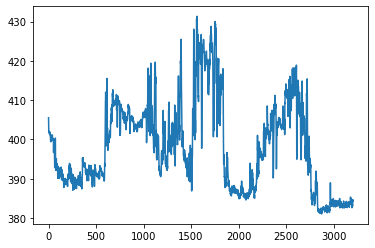

In [5]:
dirPath = '/scratch/jma819/scope_data/SPRT/m1_GRAB_analysis/'
fOut = '2024-11-14-15-21-35_channel2_dff_min.csv'
df = pd.DataFrame(avg_intensity_array, columns=["avg_intensity"])  # adjust column names if needed
df.to_csv(dirPath+fOut, index=False)
plt.plot(avg_intensity_array)
plt.show()

In [ ]:
#save smaller h5 files for viewing 
dataset_name = 'data'  # Adjust if your dataset is named differently
dirPathOut = '/scratch/jma819/scope_data/SPRT/m1_GRAB_analysis/2024-11-14-15-21-35_channel2_dff_min/'
output_prefix = '2024-11-14-15-21-35_channel2_dff_min'  # Change this to your desired prefix (or "regularExpression" variable)
chunk_size = 500  # For example, save 50 frames per file
# Call the function to split the input file
generated_files = split_h5_file_by_frames(os.path.join(dirPath, dff_file), dataset_name, dirPathOut, output_prefix, chunk_size)

In [ ]:
# Parameters
pixel_size_microns = 2.5
smoothing_scale_microns = 100
sigma = smoothing_scale_microns / (pixel_size_microns * 2.355)  # Adjusted sigma
print(f"Gaussian filter sigma: {sigma:.2f}")

In [ ]:
num_workers = cpu_count()  # Number of CPU cores for multiprocessing

# Load TIFF file
print(f"Image shape: {image_data.shape}, dtype: {image_data.dtype}")

# Compute F0 (mean across time for each pixel)
print("Computing F0 (time-averaged fluorescence)...")
F0 = np.mean(image_data, axis=0)

In [ ]:
# Define subset range
frame_start = 0  # Start frame index
frame_end = 1000  # End frame index (exclusive)
output_path = "/Users/johnmarshall/Documents/Analysis/SPRT_analysis/imagingData/SPRT_m1_d5_11_15_48_43/d5_11_15_48_43_red.tiff"
# Save the result as a multipage TIFF file
subset_data = image_data[frame_start:frame_end]

result_list = []
for frame_idx in tqdm(range(subset_data.shape[0]), desc="Processing frames"):
    result_list.append(process_frame(frame_idx))

# Convert result to a 3D numpy array
result_array = np.stack(result_list, axis=0)

In [ ]:
# Save the result as a multipage TIFF file
print(f"Saving result to {output_path}...")
tiff.imwrite(output_path, result_array.astype(np.float32), photometric='minisblack')

In [ ]:
# Perform the analysis using multiprocessing
print("Performing ΔF(t)/F0 analysis...")
with Pool(num_workers) as pool:
    result = pool.map(process_frame, range(image_data.shape[0]))

# Convert result to a 3D numpy array
result_array = np.stack(result, axis=0)

# Save the result as a multipage TIFF file
print(f"Saving result to {output_path}...")
tiff.imwrite(output_path, result_array.astype(np.float32), photometric='minisblack')

print("Analysis completed and file saved.")